# Deep Learning Tensorflow/Keras approach 
    -> Ressources: 
    https://towardsdatascience.com/building-a-multi-output-convolutional-neural-network-with-keras-ed24c7bc1178
    https://keras.io/guides/functional_api/
    (Multi-Output-Network)

# NN with single-input-single-output

## Data preprocessing

In [1]:
import pandas as pd

df = pd.read_csv("../static_merged_data.csv")
df.head()


,T_min,T_max,T_delta,Pow_mean,status
0,24.559295,27.063301,2.504006,0.0,drossel
1,24.559295,27.063301,2.504006,0.0,drossel
2,24.559295,27.063301,2.504006,0.0,drossel
3,24.559295,27.063301,2.504006,0.0,drossel
4,24.559295,27.063301,2.504006,0.0,drossel


In [2]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
# devide it into labels and features
Y = df[["status"]]
X = df[["T_min","T_max","T_delta","Pow_mean"]]

# split the dataset into train- and testset
X_train, X_test, y_train, y_test = train_test_split(X, Y, shuffle=True, test_size=.2)

#y_categ = to_categorical(Y,3) #does not work: only integers
y_train.head()

,status
28753,drossel
51406,mosfets
70913,normal
64189,mosfets
78243,normal


In [3]:
from keras.utils import to_categorical
pd_series_nums = y_train.status.astype('category').cat.codes.to_numpy()
labels = to_categorical(pd_series_nums, 3)
labels.shape

(77079, 3)

In [4]:
X_numpy = X_train.to_numpy()
#X_numpy.resize(96349,1,4)
X_numpy.shape

(77079, 4)

In [5]:
def prepare_train_test_set(X, Y, num_classes):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, shuffle=True, test_size=.2)
    print(y_train.head(5))
    train_labels = y_train.status.astype('category').cat.codes.to_numpy()
    test_labels = y_test.status.astype('category').cat.codes.to_numpy()
    print(train_labels[0:5])
    train_labels = to_categorical(train_labels, num_classes)
    test_labels = to_categorical(test_labels, num_classes)
    X_train.to_numpy()
    X_test.to_numpy()
    return (X_train, X_test), (train_labels, test_labels)

In [6]:
(X_train, X_test), (train_labels, test_labels) = prepare_train_test_set(X,Y,3)

        status
92743   normal
1424   drossel
40120  mosfets
76848   normal
42959  mosfets
[2 0 1 2 1]


## Model architecture

In [7]:
from keras.models import Model
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Input
import tensorflow as tf
from keras import Sequential
from keras.layers import Activation 

model = Sequential([
    Input(shape=(4,), name="input-layer"),
    Dense(64, activation="relu"),
    Dense(128, activation="relu"),
    Dense(128, activation="relu"),
    Dense(128, activation="relu"),
    Dense(16, activation="relu"),
    Dense(3, activation="softmax", name="output_layer")
], name="DCDC_type_classifier")

model.summary()

Model: "DCDC_type_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                320       
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 16)                2064      
                                                                 
 output_layer (Dense)        (None, 3)                 51        
                                                                 
Total params: 43,779
Trainable params: 43,779


## Training

In [28]:
from keras.losses import CategoricalCrossentropy
from keras.optimizers import Adam
model.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=["acc"])

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=(model.name + ".h5"),
    save_weights_only=False,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

history = model.fit(X_train, train_labels, 512, 100, validation_split=0.1, callbacks=[model_checkpoint_callback])

Epoch 1/100
136/136 [==============================] - 1s 7ms/step - loss: 1.0659 - acc: 0.4440 - val_loss: 0.9929 - val_acc: 0.4635
Epoch 2/100
136/136 [==============================] - 1s 5ms/step - loss: 0.9364 - acc: 0.5281 - val_loss: 0.9008 - val_acc: 0.5541
Epoch 3/100
136/136 [==============================] - 1s 5ms/step - loss: 0.8448 - acc: 0.5898 - val_loss: 0.7891 - val_acc: 0.6840
Epoch 4/100
136/136 [==============================] - 1s 5ms/step - loss: 0.7366 - acc: 0.6708 - val_loss: 0.6702 - val_acc: 0.6527
Epoch 5/100
136/136 [==============================] - 1s 6ms/step - loss: 0.6457 - acc: 0.7241 - val_loss: 0.5404 - val_acc: 0.7636
Epoch 6/100
136/136 [==============================] - 1s 6ms/step - loss: 0.5355 - acc: 0.7726 - val_loss: 0.5125 - val_acc: 0.7304
Epoch 7/100
136/136 [==============================] - 1s 6ms/step - loss: 0.4686 - acc: 0.8082 - val_loss: 0.3902 - val_acc: 0.8595
Epoch 8/100
136/136 [==============================] - 1s 5ms/step - 

## Evaluation

In [29]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

def plot_history(history, epochs_size):
    loss_list = []
    accuracy_list = []
    history_keys = history.history.keys()
    for key in history_keys:
        if "loss" in key:
            loss_list.append(key)
        
        elif "acc" in key:
            accuracy_list.append(key)
        
        elif "accuracy" in key:
            accuracy_list.append(key)

    print(loss_list)
    print(accuracy_list)
    
    colors = list(mcolors.BASE_COLORS.keys())
    epochs = range(1, (epochs_size+1))
    ig, ax = plt.subplots(2, figsize=(20, 8))

    for key,color in zip(loss_list, colors):
        ax[0].plot(epochs ,history.history[key], str(color), label=str(key))

    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("%")
    ax[0].set_title("Loss of Model:")
    ax[0].legend()

    for key,color in zip(accuracy_list, colors):
        ax[1].plot(epochs, history.history[key], str(color), label=str(key))
        
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("%")
    ax[1].set_title("Accuracy of Model:")
    ax[1].legend()

    # set the spacing between subplots
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.8)

    plt.show()
    

['loss', 'val_loss']
['acc', 'val_acc']


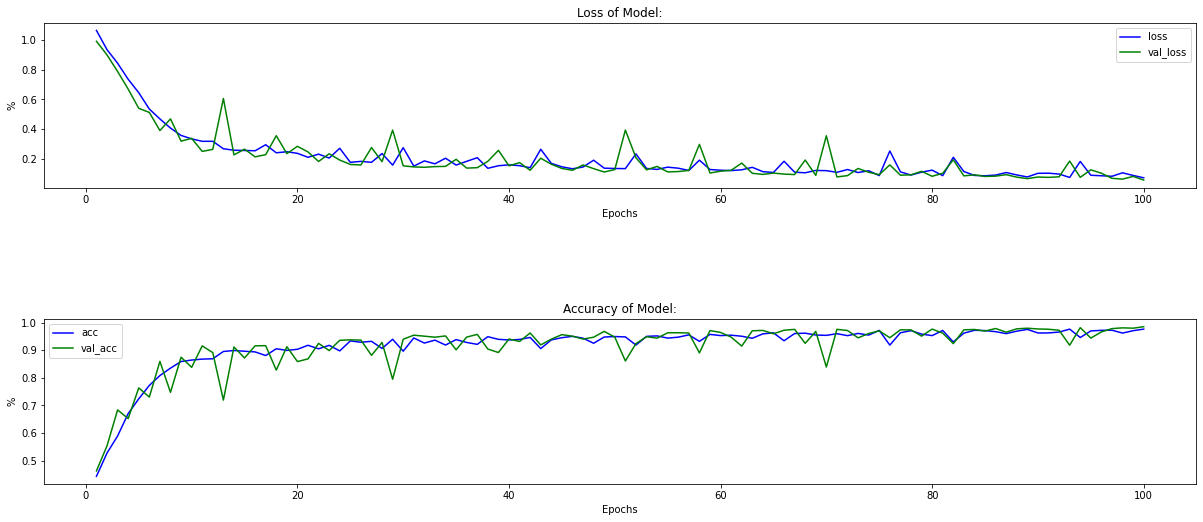

In [30]:
plot_history(history=history, epochs_size=100)

In [42]:
print("Accuracy on the Test-Dataset: {:.2f}% ".format(model.evaluate(X_test, test_labels)[1]*100))

603/603 [==============================] - 1s 1ms/step - loss: 0.0576 - acc: 0.9849
Accuracy on the Test-Dataset: 98.49% 


In [16]:
from keras.models import load_model
import tensorflow as tf
import numpy as np

test = np.array([[
  50.60096153846154,
  51.10176282051282,
  0.5008012820512775,
  45.57217712402344]])

print(test.shape)

model = load_model("DCDC_type_classifier.h5")
model.predict(test)
# Convert the model.
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()

# # Save the model.
# with open('model.tflite', 'wb') as f:
#   f.write(tflite_model)

(1, 4)
1/1 [==============================] - 0s 124ms/step


array([[9.6895885e-01, 2.9721745e-05, 3.1011499e-02]], dtype=float32)

# NN with single-input-multi-output

## Data Preprocessing

In [44]:
df_audio = pd.read_csv("../audio_merged_data.csv")
df_audio.head()

,T_min,T_max,T_delta,Pow_mean,status,songtitle
0,24.058494,26.562500,2.504006,18.992137,drossel,neelix
1,24.308894,26.812901,2.504006,19.233031,drossel,neelix
2,24.308894,26.812901,2.504006,19.135991,drossel,neelix
3,24.308894,26.812901,2.504006,19.350136,drossel,neelix
4,24.308894,26.812901,2.504006,19.545401,drossel,neelix


In [45]:
X_audio = df_audio[["T_min", "T_max", "T_delta", "Pow_mean"]]
y_audio = df_audio[["status", "songtitle"]]

def prepare_multi_output_train_test_set(X, Y, num_converters, num_songs):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, shuffle=True, test_size=.2)
    conv_train_labels = y_train.status.astype('category').cat.codes.to_numpy()
    conv_test_labels = y_test.status.astype('category').cat.codes.to_numpy()
    song_train_labels = y_train.songtitle.astype('category').cat.codes.to_numpy()
    song_test_labels = y_test.songtitle.astype('category').cat.codes.to_numpy()
    conv_train_labels = to_categorical(conv_train_labels, num_converters)
    conv_test_labels = to_categorical(conv_test_labels, num_converters)
    song_train_labels = to_categorical(song_train_labels, num_songs)
    song_test_labels = to_categorical(song_test_labels, num_songs)
    X_train.to_numpy()
    X_test.to_numpy()
    return (X_train, X_test), (conv_train_labels, conv_test_labels), (song_train_labels, song_test_labels)
(X_train, X_test), (conv_train_labels, conv_test_labels), (song_train_labels, song_test_labels) = prepare_multi_output_train_test_set(X_audio, y_audio, 3, 3)

## Model architecture

In [46]:
class ConverterClassifier():
    
    def make_default_hidden_layers(self, inputs):
        x = Dense(64)(inputs)
        x = Activation("relu")(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = Dense(16)(x)
        x = Activation("relu")(x)
        return x

    def build_converter_branch(self, inputs, num_of_converters):
        x = self.make_default_hidden_layers(inputs)
        x = Dense(num_of_converters)(x)
        x = Activation("softmax", name="converter_output")(x)
        return x

    def build_song_branch(self, inputs, num_of_songs):
        x = self.make_default_hidden_layers(inputs)
        x = Dense(num_of_songs)(x)
        x = Activation("softmax", name="song_output")(x)
        return x

    def assemble_full_model(self, input_shape, num_converters, num_songs):
        """
        Used to assemble our multi-output model CNN.
        """
        inputs = Input(shape=input_shape)
        converter_branch = self.build_converter_branch(inputs, num_converters)
        song_branch = self.build_song_branch(inputs, num_songs)
        model = Model(inputs=inputs,
                     outputs = [converter_branch, song_branch],
                     name="converter_net")
        return model

In [47]:
model = ConverterClassifier().assemble_full_model((4,), num_converters=3, num_songs=3)

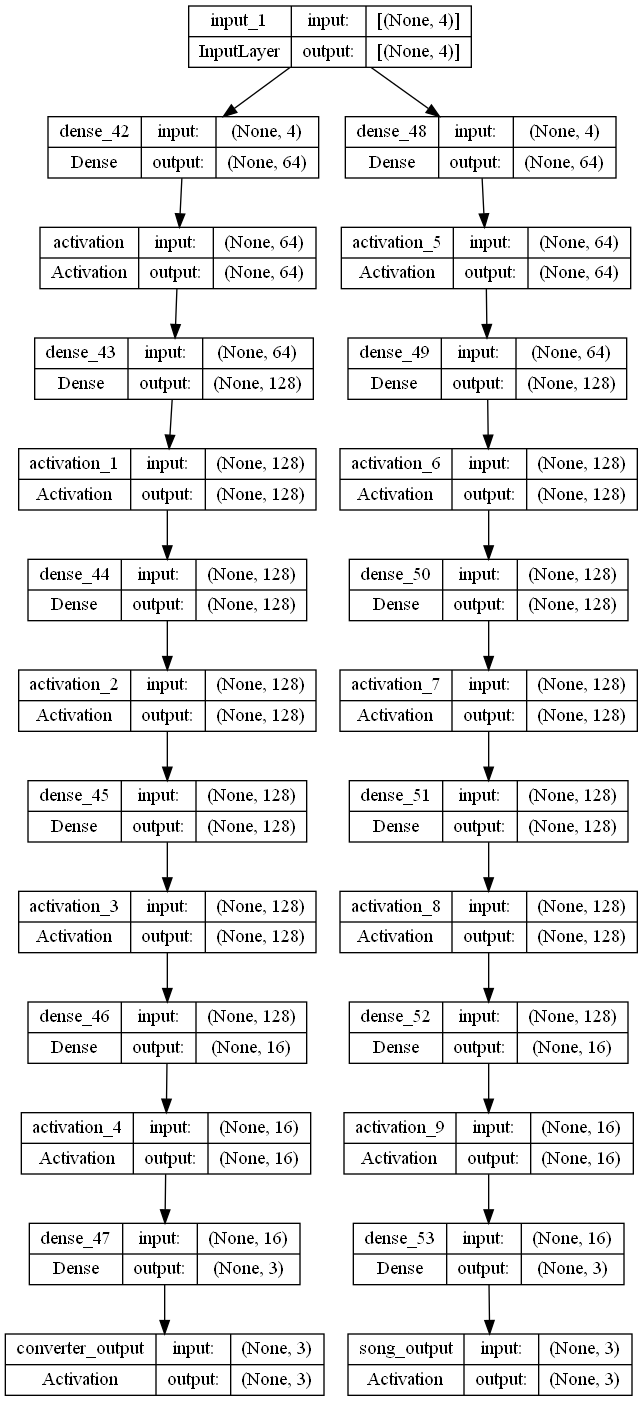

In [48]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True)

## Training

In [49]:
from keras.optimizers import Adam
init_lr = 1e-4
epochs = 100
opt = Adam(learning_rate=init_lr, decay=init_lr / epochs)
model.compile(optimizer=opt, 
              loss={
                  'converter_output': 'categorical_crossentropy', 
                  'song_output': 'categorical_crossentropy'},
    
              metrics={
                  'converter_output': 'accuracy',
                  'song_output': 'accuracy'})

In [50]:
history = model.fit(X_train, [conv_train_labels, song_train_labels], batch_size=128, epochs=epochs, validation_split=.1)

Epoch 1/100
49/49 [==============================] - 1s 9ms/step - loss: 2.7491 - converter_output_loss: 1.4930 - song_output_loss: 1.2561 - converter_output_accuracy: 0.3331 - song_output_accuracy: 0.3862 - val_loss: 2.0873 - val_converter_output_loss: 1.0850 - val_song_output_loss: 1.0024 - val_converter_output_accuracy: 0.3721 - val_song_output_accuracy: 0.3348
Epoch 2/100
49/49 [==============================] - 0s 4ms/step - loss: 2.0212 - converter_output_loss: 1.0714 - song_output_loss: 0.9498 - converter_output_accuracy: 0.3873 - song_output_accuracy: 0.4608 - val_loss: 2.0241 - val_converter_output_loss: 1.0819 - val_song_output_loss: 0.9422 - val_converter_output_accuracy: 0.3247 - val_song_output_accuracy: 0.5790
Epoch 3/100
49/49 [==============================] - 0s 4ms/step - loss: 1.9775 - converter_output_loss: 1.0625 - song_output_loss: 0.9150 - converter_output_accuracy: 0.3868 - song_output_accuracy: 0.5911 - val_loss: 1.9758 - val_converter_output_loss: 1.0654 - val

## Evaluation

In [51]:
import matplotlib.colors as mcolors

def plot_history(history, epochs_size):
    loss_list = []
    accuracy_list = []
    history_keys = history.history.keys()
    for key in history_keys:
        if "loss" in key:
            loss_list.append(key)
        
        elif "accuracy" in key:
            accuracy_list.append(key)

    print(loss_list)
    print(accuracy_list)
    
    colors = list(mcolors.BASE_COLORS.keys())
    epochs = range(1, (epochs_size+1))
    ig, ax = plt.subplots(2, figsize=(20, 8))

    for key,color in zip(loss_list, colors):
        ax[0].plot(epochs ,history.history[key], str(color), label=str(key))

    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("%")
    ax[0].set_title("Loss of Model:")
    ax[0].legend()

    for key,color in zip(accuracy_list, colors):
        ax[1].plot(epochs, history.history[key], str(color), label=str(key))
        
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("%")
    ax[1].set_title("Accuracy of Model:")
    ax[1].legend()

    # set the spacing between subplots
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.8)

    plt.show()

['loss', 'converter_output_loss', 'song_output_loss', 'val_loss', 'val_converter_output_loss', 'val_song_output_loss']
['converter_output_accuracy', 'song_output_accuracy', 'val_converter_output_accuracy', 'val_song_output_accuracy']


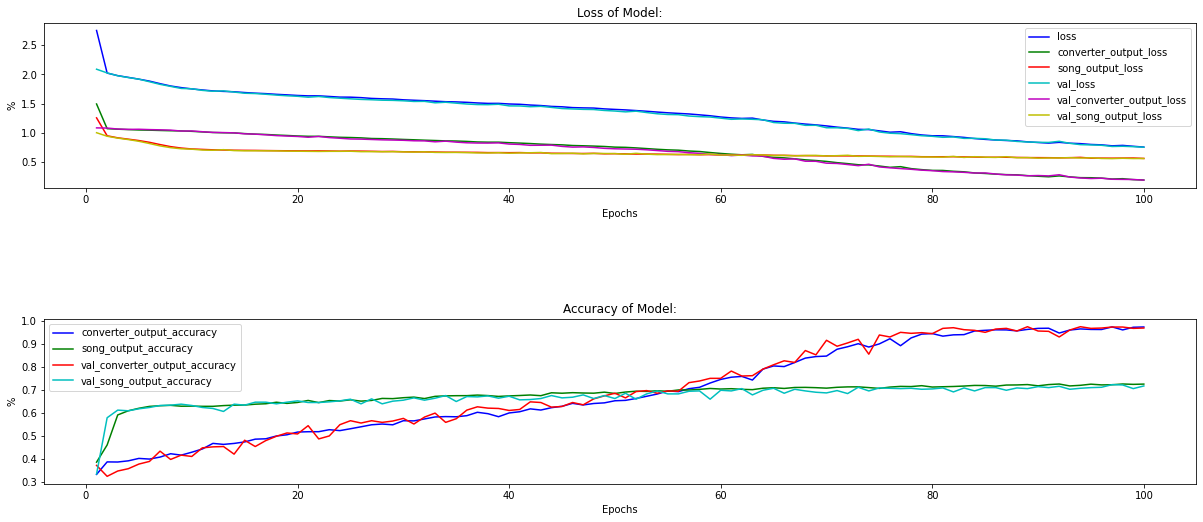

In [52]:
plot_history(history, epochs)

In [60]:
model_score = model.evaluate(X_test, [conv_test_labels, song_test_labels])[3:]
print("Accuracy on the Test-Dataset:")
print("Converter Classifier: {:.2f}%".format(model_score[0]*100))
print("Song Classifier: {:.2f}%".format(model_score[1]*100))

55/55 [==============================] - 0s 2ms/step - loss: 0.7453 - converter_output_loss: 0.1838 - song_output_loss: 0.5615 - converter_output_accuracy: 0.9770 - song_output_accuracy: 0.7297
Accuracy on the Test-Dataset:
Converter Classifier: 97.70%
Song Classifier: 72.97%


## To Do
    - improve song classifier
    - add more comments
    - add model checkpoint callback for multi-ouput-model
    - transform into tf-lite model
    - test with Sven if multi-output-sklearn-classifier can be ported
    - make a textfile/table to show and compare the different classifers and their scores